In [38]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np



In [39]:
BATCH_SIZE = 8
LR = 3e-5
NUM_EPOCHS = 10
EARLY_STOPPING_PATIENCE = 5

# BATCH_SIZE = 8
# LR = 3e-5
# NUM_EPOCHS = 10

# second best
# BATCH_SIZE = 16
# LR = 3e-5
# NUM_EPOCHS = 10

# BATCH_SIZE = 16
# LR = 2e-5
# NUM_EPOCHS = 10


# BATCH_SIZE = 16
# LR = 5e-5
# NUM_EPOCHS = 10

#best
# BATCH_SIZE = 8
# LR = 2e-5
# NUM_EPOCHS = 10
# EARLY_STOPPING_PATIENCE = 5

# BATCH_SIZE = 16
# LR = 1e-5
# NUM_EPOCHS = 10

# BATCH_SIZE = 8
# LR = 1e-5
# NUM_EPOCHS = 10

In [40]:
data = pd.read_csv('/Users/vladcalomfirescu/Desktop/MyFiles/DEV/ML/Veridion-Project/data1/all_data.csv')
data['Label'] = (data['Label'] == 'PRODUCT').astype(int)
data['Text'] = data['Text'].str.title()

print(data.head(3))

                                                Text  Label
0         Factory Buys 32Cm Euro Top Mattress - King      1
1  Savannah Grey Bed Frame Fabric Gas Lift Storag...      1
2  Azalea Led Bed Frame Pu Leather Gas Lift Stora...      1


In [41]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenized_data = tokenizer(list(data['Text']), truncation=True, padding=True, return_tensors='pt', max_length=128)

labels = torch.tensor(list(data['Label']))

dataset = torch.utils.data.TensorDataset(tokenized_data['input_ids'], tokenized_data['attention_mask'], labels)

train_dataset, val_dataset = train_test_split(dataset, test_size=0.1, random_state=42)


In [42]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
optimizer = AdamW(model.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
loss_fn = torch.nn.BCEWithLogitsLoss()

best_val_loss = float('inf')
early_stopping_counter = 0

/Users/vladcalomfirescu/Desktop/MyFiles/DEV/ML/Veridion-Project/.venv/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [44]:
# for epoch in range(NUM_EPOCHS):
#         model.train()
#         total_loss = 0

#         for batch in train_loader:
#             input_ids, attention_mask, labels = batch

#             optimizer.zero_grad()

#             outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels.unsqueeze(1).float())
#             loss = outputs.loss
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item()

#         print(f'Epoch {epoch + 1}/{NUM_EPOCHS}, Loss: {total_loss / len(train_loader)}')

#         model.eval()
#         val_predictions = []
#         val_labels = []

#         with torch.no_grad():
#             for batch in val_loader:
#                 input_ids, attention_mask, labels = batch

#                 outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#                 predictions = torch.sigmoid(outputs.logits.squeeze())

#                 val_predictions.extend(predictions.cpu().numpy())
#                 val_labels.extend(labels.cpu().numpy())

#         val_loss = loss_fn(torch.tensor(val_predictions).squeeze(), torch.tensor(val_labels).float())

#         scheduler.step(val_loss)

#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             early_stopping_counter = 0
#         else:
#             early_stopping_counter += 1
#             if early_stopping_counter >= EARLY_STOPPING_PATIENCE:
#                 print(f'Early stopping after {epoch + 1} epochs')
#                 break


Epoch 1/10, Training Loss: 0.08345414102077484
Validation Loss: 0.3919040858745575
Epoch 2/10, Training Loss: 0.011596206395188347
Validation Loss: 0.3941197991371155
Epoch 3/10, Training Loss: 0.009037444146815687
Validation Loss: 0.3911704421043396
Epoch 4/10, Training Loss: 0.007618008169811219
Validation Loss: 0.3970574140548706
Epoch 5/10, Training Loss: 0.0071809474262408916
Validation Loss: 0.39374926686286926
Epoch 6/10, Training Loss: 0.005137972277589142
Validation Loss: 0.3912927210330963
Epoch 00006: reducing learning rate of group 0 to 3.0000e-06.
Epoch 7/10, Training Loss: 0.0031032066908665
Validation Loss: 0.39414337277412415
Epoch 8/10, Training Loss: 0.004023313918150961
Validation Loss: 0.393717885017395
Early stopping after 8 epochs


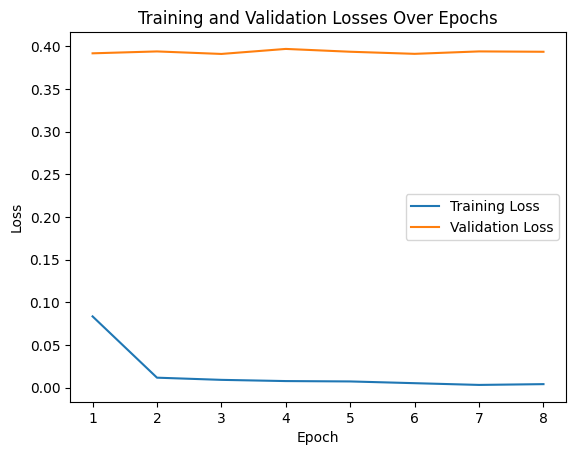

In [45]:
train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels.unsqueeze(1).float())
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calculate and store training loss
    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)

    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}, Training Loss: {train_loss}')

    model.eval()
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.sigmoid(outputs.logits.squeeze())

            val_predictions.extend(predictions.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss = loss_fn(torch.tensor(val_predictions).squeeze(), torch.tensor(val_labels).float())
    val_losses.append(val_loss.item())

    print(f'Validation Loss: {val_loss}')

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= EARLY_STOPPING_PATIENCE:
            print(f'Early stopping after {epoch + 1} epochs')
            break

epochs = np.arange(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.show()

In [15]:
model.save_pretrained('furniture_model1')

In [19]:
loaded_model = BertForSequenceClassification.from_pretrained('furniture_model1')

def predict_text(model, text, threshold=0.5):
    model.eval()
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors='pt', max_length=128)
    outputs = loaded_model(**inputs)
    prediction = torch.sigmoid(outputs.logits.squeeze()).item()

    print(f"Predicted Probability: {prediction}")

    if prediction >= threshold:
        print("Predicted Label: Furniture")
    else:
        print("Predicted Label: Not Furniture")

predict_text(loaded_model, "Azalea Bed Frame", threshold=0.73)

Predicted Probability: 0.739781379699707
Predicted Label: Furniture
